# Risco de crédito

## 1. Introdução

O risco de crédito refere-se à probabilidade de um mutuário não conseguir reembolsar um empréstimo contratado por um credor. Assim, ao longo dos anos, as instituições financeiras desenvolveram diversas formas de quantificar esse risco de forma a limitar a sua exposição.

Aqui, em vez de simplesmente modelar se um mutuário pagará ou não, usando a Análise de Sobrevivência, torna-se possível determinar quando isso acontecerá. De fato, é fácil considerar que o reembolso total de um empréstimo é um evento explícito e, portanto, não ter pago o empréstimo ainda pode ser definido como a situação censurada.

Ao usar essa configuração, bancos, cooperativas de crédito ou startups de fintech no espaço de empréstimos podem prever a velocidade de pagamento de um empréstimo. Isso ajudará essas instituições a mitigar perdas devido a dívidas incobráveis, personalizar taxas de juros, melhorar o fluxo de caixa e cobranças de crédito e determinar quais clientes provavelmente gerarão mais receita em uma variedade de produtos.

![](https://cdn.pixabay.com/photo/2016/07/06/16/22/debt-1500774_960_720.png)

## 2 - Contexto

Neste tutorial, usaremos o conjunto de dados German Credit, que foi originalmente fornecido pelo Professor Dr. Hans Hofmann da Universidade de Hamburgo e disponível no Repositório de Aprendizado de Máquina da UCI. A versão atual foi adaptada para ser usada diretamente com uma quantidade mínima de transformação de recursos.

## 3 - Conjunto de dados
### 3.1 - Descrição e visão geral

O conjunto de dados contém informações úteis para avaliar a qualidade de crédito dos mutuários, bem como elementos sociodemográficos:

**duration:** Duração em meses

**full_repaid:** Especifica se o empréstimo foi totalmente reembolsado

**age:** Idade do mutuário (em anos)

**foreign_worker:** Indica se o mutuário é um trabalhador estrangeiro

**personal_status:** Gênero e estado civil

**people_liable:** Número de pessoas responsáveis pela manutenção

**telephone:** Indica se o mutuário possui um telefone

**employment_years:** Anos de trabalho no emprego atual

**job:** Situação de emprego

**housing:** Situação residencial do mutuário

**present_residence:** Anos morando na residência atual

**amount:** Quantidade de dinheiro emprestado

**installment_rate:** Porcentagem do valor emprestado que será cobrado por um credor de um devedor

**purpose:** Motivo para obter um empréstimo.

**checking_account_status:** Situação da conta corrente

**credit_history:** Histórico de crédito do mutuário

**number_of_credits:** Número de créditos existentes neste banco

**other_installment_plans:** Tipo de planos de parcelas que o mutuário já possui

**savings_account_status:** Situação da conta poupança

**property:** Tipo de ativos valiosos que o mutuário possui

**other_debtors:** Indique se outra pessoa estará envolvida no pagamento ou está garantindo o empréstimo


In [20]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset

# Reading the dataset
raw_dataset = Dataset('credit_risk').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head()

The raw_dataset has the following shape: (1000, 21).


,checking_account_status,duration,credit_history,purpose,amount,savings_account_status,employment_years,installment_rate,personal_status,other_debtors,...,property,age,other_installment_plans,housing,number_of_credits,job,people_liable,telephone,foreign_worker,full_repaid
0,below_0,6,critical_account,radio_TV,1169,unknown,above_7,4,M_single,None,...,real_estate,67,None,own,2,official,1,1,1,1
1,0_to_200,48,existing_credit_paid,radio_TV,5951,below_100,between_1_4,2,F_not_single,None,...,real_estate,22,None,own,1,official,1,0,1,0
2,no_account,12,critical_account,education,2096,below_100,between_4_7,2,M_single,None,...,real_estate,49,None,own,1,unskilled,2,0,1,1
3,below_0,42,existing_credit_paid,furniture_equipment,7882,below_100,between_4_7,2,M_single,guarantor,...,life_insurance,45,None,free,1,official,2,0,1,1
4,below_0,24,delay_in_paying,car_new,4870,below_100,between_1_4,3,M_single,None,...,no_property,53,None,free,2,official,2,0,1,0


In [21]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   checking_account_status  1000 non-null   object
 1   duration                 1000 non-null   int64 
 2   credit_history           1000 non-null   object
 3   purpose                  1000 non-null   object
 4   amount                   1000 non-null   int64 
 5   savings_account_status   1000 non-null   object
 6   employment_years         1000 non-null   object
 7   installment_rate         1000 non-null   int64 
 8   personal_status          1000 non-null   object
 9   other_debtors            1000 non-null   object
 10  present_residence        1000 non-null   int64 
 11  property                 1000 non-null   object
 12  age                      1000 non-null   int64 
 13  other_installment_plans  1000 non-null   object
 14  housing                  1000 non-null   

### 3.2 - Transformação das variáveis categóricas

Existem vários recursos categóricos que precisam ser codificados em vetores one-hot:

In [22]:
# From category to numerical
categories = [
    'checking_account_status', 'credit_history', 'purpose',
    'savings_account_status', 'employment_years', 'personal_status',
    'other_debtors', 'property', 'other_installment_plans', 'housing', 'job']
dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)

# Creating the time and event columns
time_column = 'duration'
event_column = 'full_repaid'

# Creating the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

## 4 - Análise Exploratória de Dados

Faremos uma análise exploratória de dados mais detalhada aqui. Vamos verificar se o conjunto de dados contém valores nulos ou se possui linhas duplicadas, verificar as correlações entre as variáveis, etc.

### 4.1 - Valores nulos e duplicados

A primeira coisa a fazer é verificar se o raw_dataset contém valores Null e tem linhas duplicadas.

In [23]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


O conjunto de dados não possui valores nulos ou duplicados.

### 4.2 - Correlações

Vamos calcular e visualizar a correlação entre as variáveis

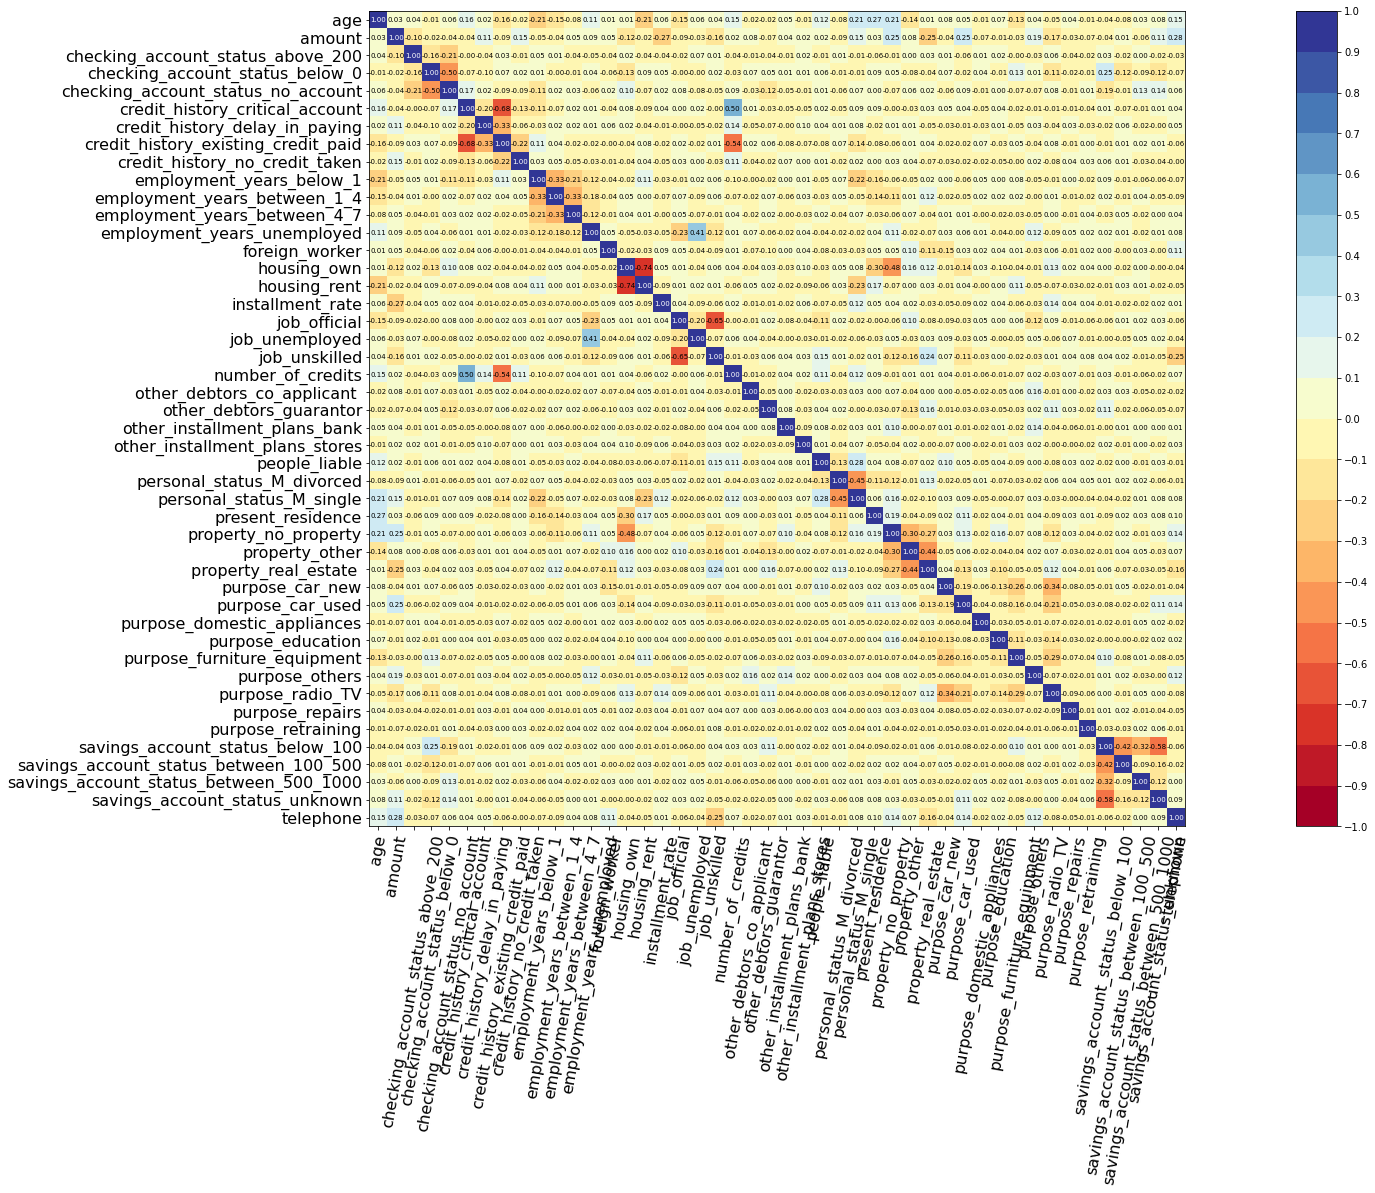

In [24]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(40,15), text_fontsize=7)

Com base no gráfico de correlações, devemos remover as seguintes variáveis:

- credit_history_existing_credit_paid
- housing_own

In [25]:
to_remove = ['credit_history_existing_credit_paid', 'housing_own']
features = np.setdiff1d(features, to_remove).tolist()

### 4.3 - Visualização dos dados

Vamos conferir/visualizar as estatísticas das variáveis: 

#### 4.2.1 - Variáveis numéricas 

Vamos exibir o boxplot e o histograma de cada feature.

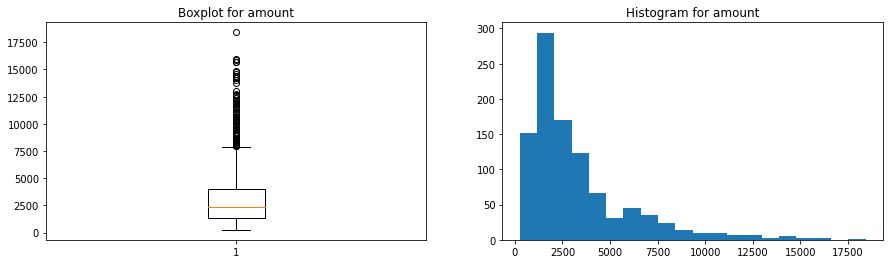

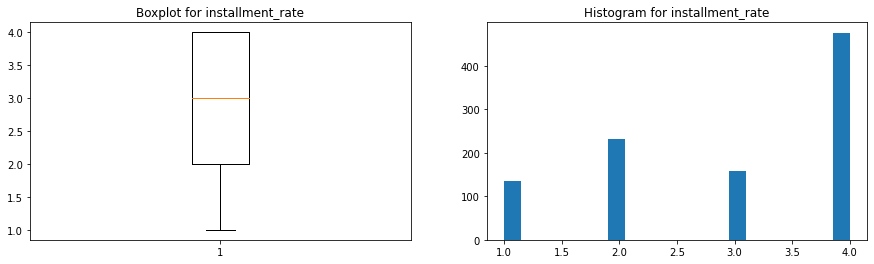

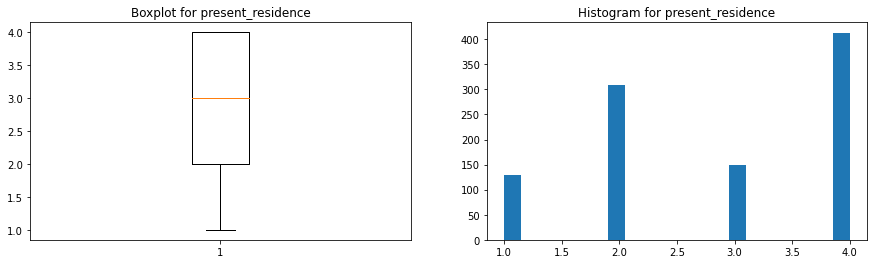

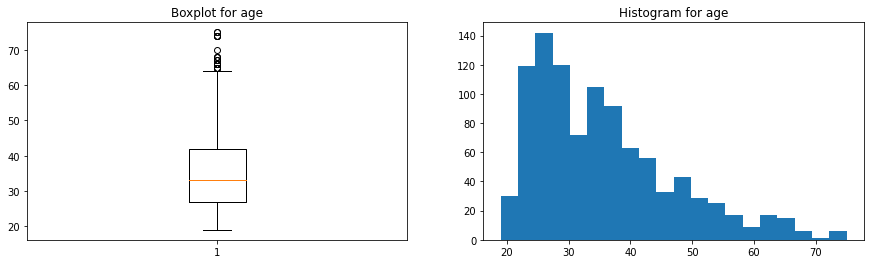

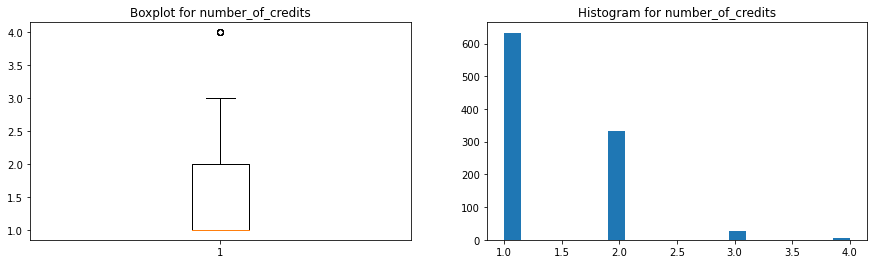

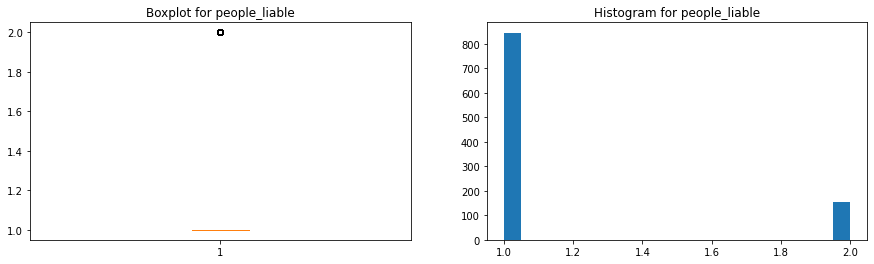

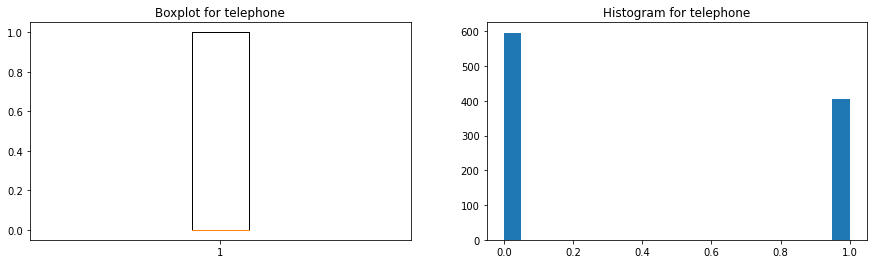

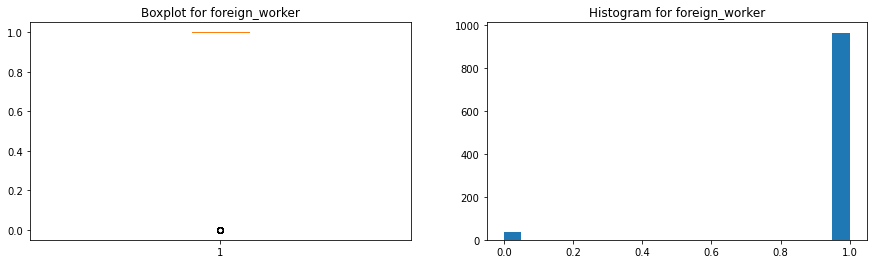

In [26]:
numerical = ['amount', 'installment_rate', 'present_residence', 'age',
       'number_of_credits', 'people_liable', 'telephone', 'foreign_worker']

for feature in numerical:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title('Boxplot for {}'.format(feature))

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title('Histogram for {}'.format(feature))

    # Display
    plt.show()

Algumas features possuem muitos outliers, porém não iremos removê-los. Além disso, algumas variáveis não parecem ser uniformemente distribuídas.

#### 4.2.2 - Variáveis categóricas

Vamos exibir as ocorrências das categorias em um gráfico de barras para cada recurso

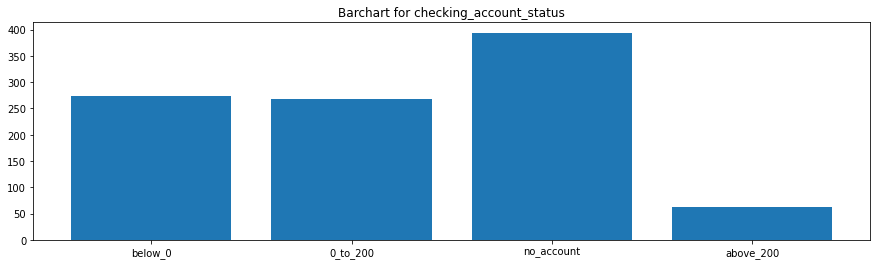

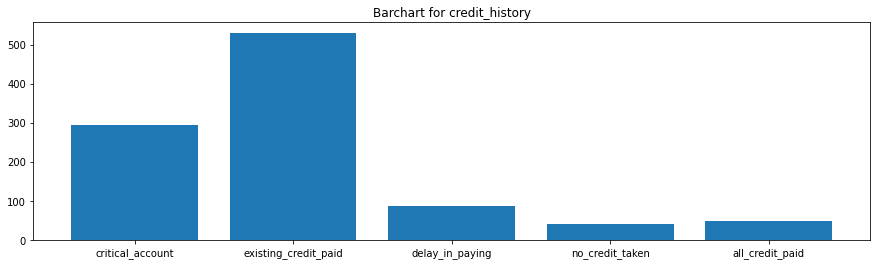

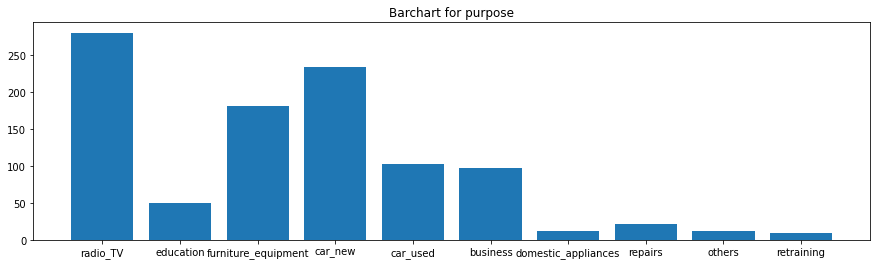

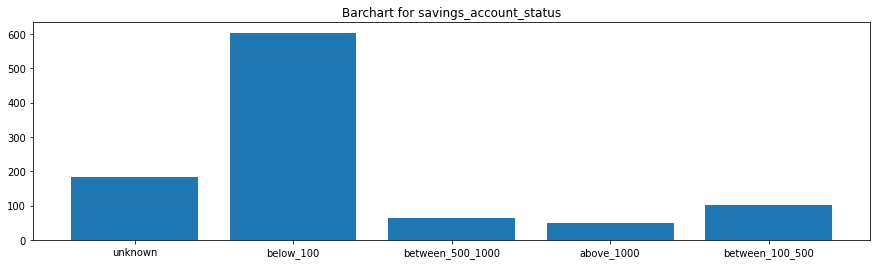

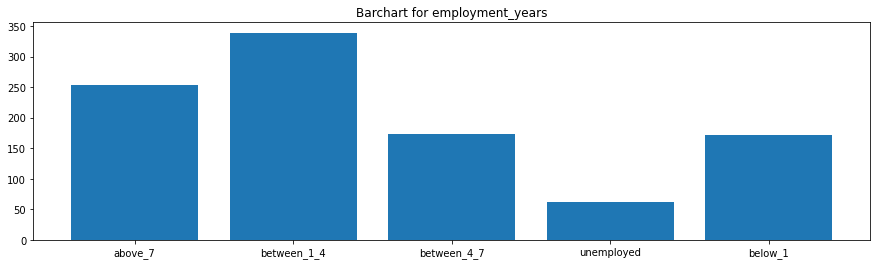

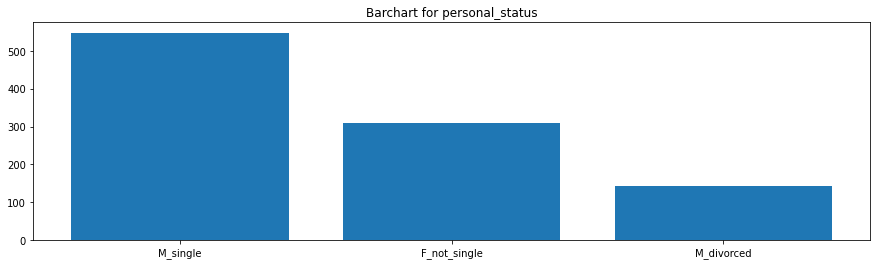

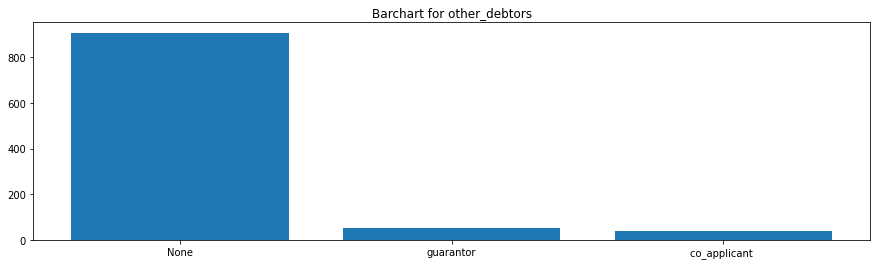

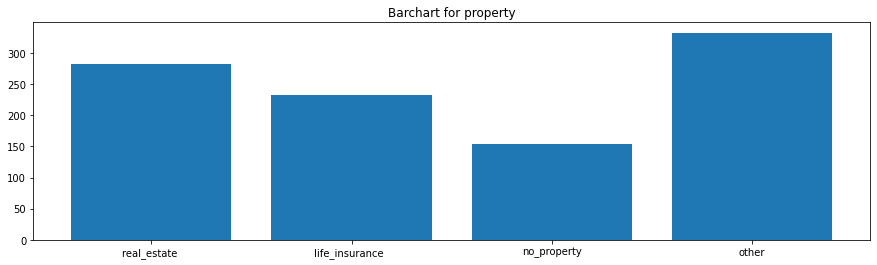

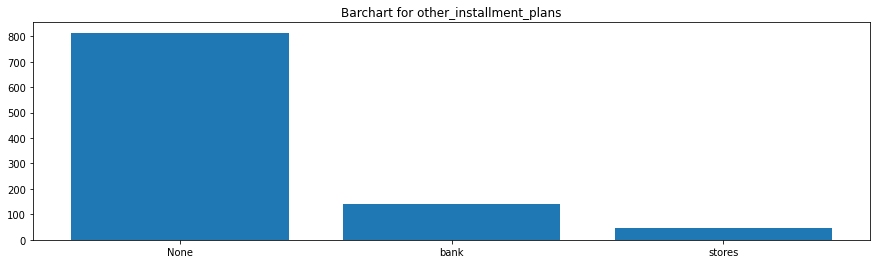

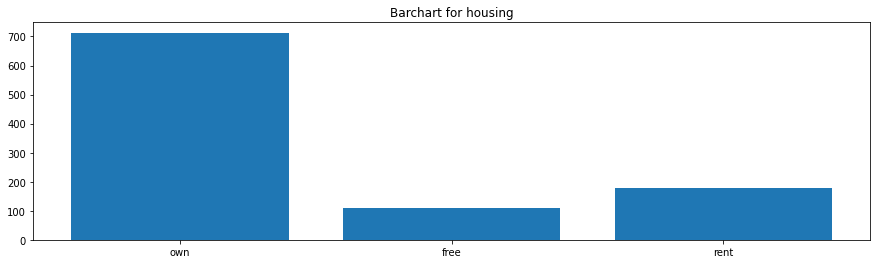

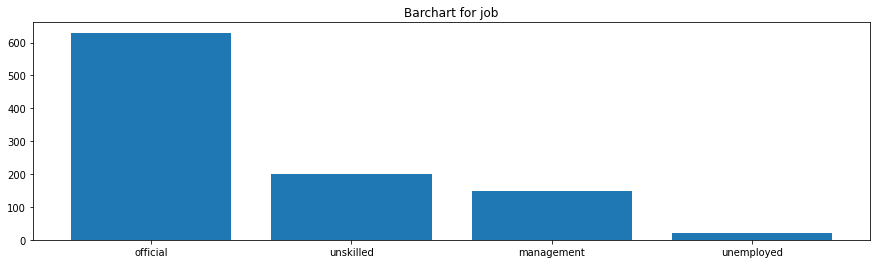

In [27]:
from collections import Counter

for feature in categories:

    # Creating an empty chart
    fig, ax = plt.subplots(figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Counting the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    ax.bar(category, counts)

    # Display
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()

#### 4.2.3 - Tempo & Evento

Mostraremos as ocorrências de evento e censura, bem como a distribuição da variável de saída para ambas as situações.

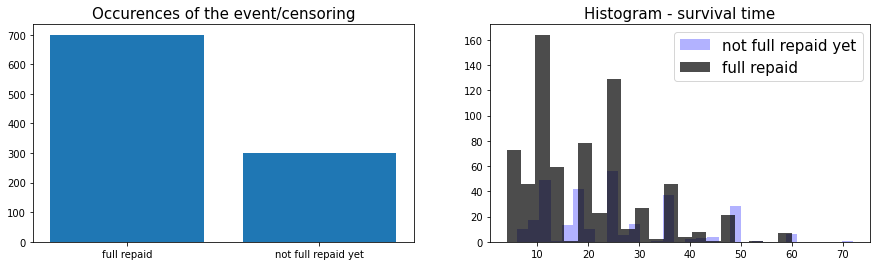

In [28]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['full_repaid'].replace({0:'not full repaid yet', 1:'full repaid'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['full_repaid'] == 0, 'duration']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not full repaid yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['full_repaid'] == 1, 'duration']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'full repaid')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

Aqui, podemos ver que aproximadamente 3/7 dos dados são censurados.

## 5 - Modelagem
### 5.1 - Construindo o modelo

Para realizar a validação cruzada posteriormente e avaliar o desempenho do modelo, vamos dividir o conjunto de dados em conjuntos de treinamento e teste.


In [29]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split( range(N), test_size = 0.4, random_state = 42)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]


Agora, vamos ajustar um modelo *NEURAL MTLR* ao conjunto de treinamento.

In [30]:
from pysurvival.models.multi_task import NeuralMultiTaskModel

# Initializing the Neural MTLR with a time axis split into 100 intervals
structure = [{'activation': 'ReLU', 'num_units': 60}, {'activation': 'Swish', 'num_units': 60}]
neural_mtlr = NeuralMultiTaskModel(bins=100, structure=structure)

# Fitting the model
neural_mtlr.fit(X_train, T_train, E_train, optimizer = 'sgd',
                init_method='orthogonal', lr=1e-4,
                l2_reg=1e-1,  l2_smooth=1e-1,
                batch_normalization=True,  bn_and_dropout=True,
                dropout=0.5,  num_epochs=500)

% Completion: 100%|**********************************************|Loss: 1142.82


NeuralMultiTaskModel( Layer(1): activation = ReLU, units = 60 ; 
                      Layer(2): activation = Swish, units = 60 )

Podemos dar uma olhada nos valores da função de perda N-MTLR para garantir que o ajuste não esteja incompleto.

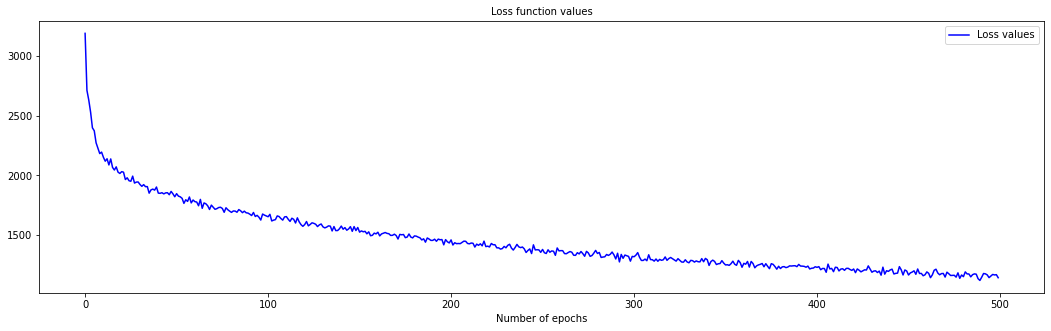

In [31]:
from pysurvival.utils.display import display_loss_values
display_loss_values(neural_mtlr)

## 6 - Validação Cruzada

Para avaliar o desempenho do modelo, dividimos anteriormente o conjunto de dados original em conjuntos de treinamento e teste, para que agora possamos calcular suas métricas de desempenho no conjunto de teste:

### 6.1 - C-index

O índice C representa a avaliação global do poder de discriminação do modelo: esta é a capacidade do modelo de fornecer corretamente uma classificação confiável dos tempos de sobrevivência com base nas pontuações de risco individuais. Em geral, quando o índice C está próximo de 1, o modelo tem um poder discriminatório quase perfeito; mas se for próximo de 0,5, não tem capacidade de discriminar entre indivíduos de baixo e alto risco.

In [32]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(neural_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.68


### 6.2 - Brier Score

A pontuação de Brier mede as discrepâncias médias entre o status e as probabilidades estimadas em um determinado momento. Assim, quanto menor a pontuação (geralmente abaixo de 0,25), melhor o desempenho preditivo. Para avaliar a medida de erro geral em vários pontos de tempo, o Integrated Brier Score (IBS) geralmente também é calculado.


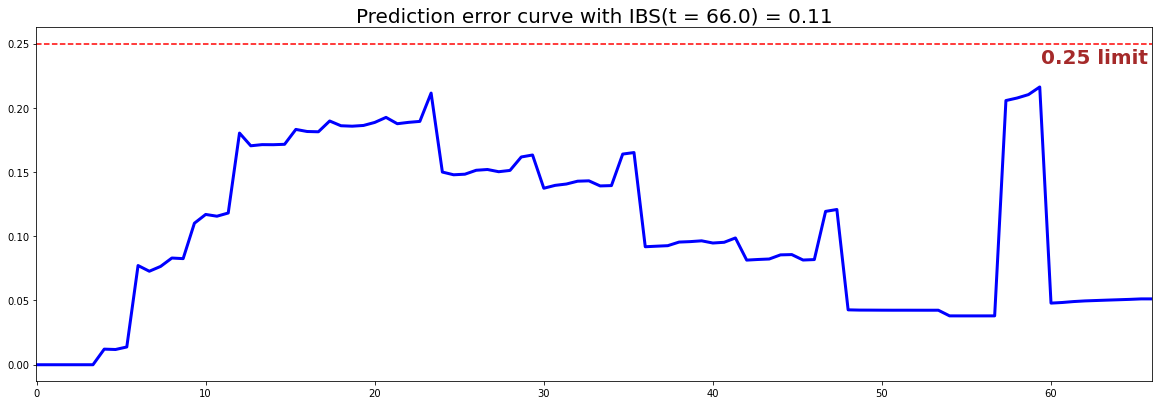

IBS: 0.11


In [33]:
from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(neural_mtlr, X_test, T_test, E_test, t_max=100, figure_size=(20, 6.5))
print('IBS: {:.2f}'.format(ibs))

## 7 - Previsões

### 7.1 - Previsões gerais

Agora que construímos um modelo que parece fornecer bons desempenhos, vamos comparar o seguinte:

- a série temporal do número real e previsto de empréstimos que foram totalmente reembolsados, para cada tempo $t$.

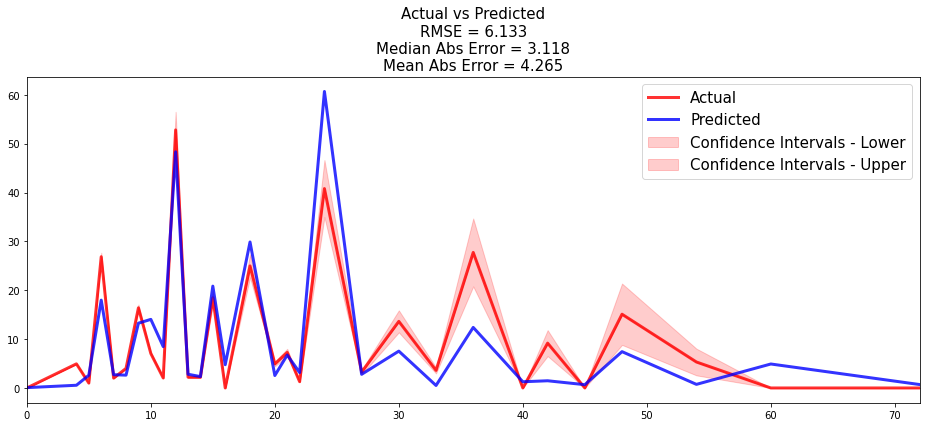

In [34]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(neural_mtlr, X_test, T_test, E_test, is_at_risk = False, figure_size=(16, 6), metrics = ['rmse', 'mean', 'median'])

- a série temporal do número real e previsto de empréstimos que ainda estavam ativos, para cada tempo $t$.

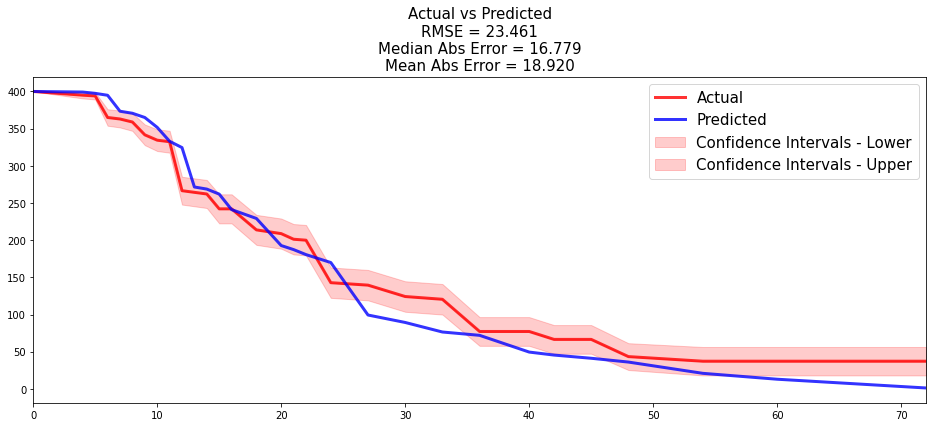

In [35]:
results = compare_to_actual(neural_mtlr, X_test, T_test, E_test,is_at_risk = True,  figure_size=(16, 6), metrics = ['rmse', 'mean', 'median'])

Ambas as comparações mostram que o modelo faz um ótimo trabalho ao prever o número de empréstimos que foram totalmente reembolsados (erro absoluto médio de 4,5 empréstimos) ou que ainda estavam ativos (erro absoluto médio de 20,8 empréstimos) para todos os tempos $t$ em uma janela de mais de 70 meses.

### 7.2 - Previsões individuais

Agora que sabemos que podemos fornecer previsões confiáveis para uma grupo inteiro, vamos calcular a velocidade de pagamento no nível individual. A velocidade de reembolso é dada por $Speed(t)=1−Survival(t)$

Primeiro, podemos construir os grupos de risco com base na distribuição dos escores de risco. A função auxiliar `create_risk_groups`, que pode ser encontrada em `pysurvival.utils`, nos ajudará a fazer isso:

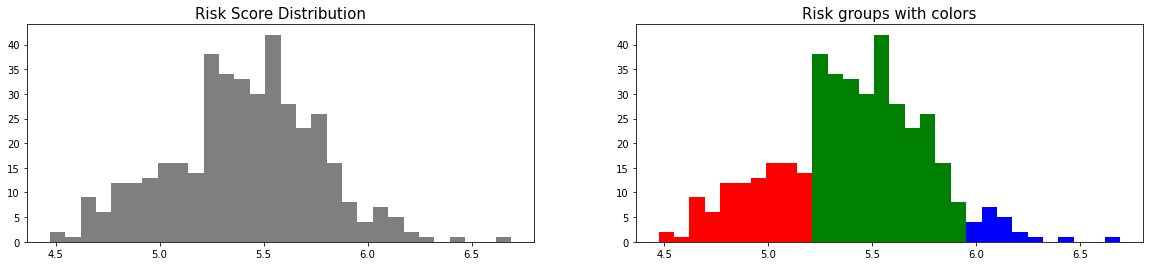

In [36]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=neural_mtlr, X=X_test,
    use_log = True, num_bins=30, figure_size=(20, 4),
    low= {'lower_bound':0, 'upper_bound':5.2, 'color':'red'},
    medium= {'lower_bound': 5.2, 'upper_bound':5.9, 'color':'green'},
    high= {'lower_bound':5.9, 'upper_bound':7, 'color':'blue'}
    )

Aqui, é possível distinguir 3 grupos principais, grupos de baixo, médio e alto risco. Como o índice C é alto, o modelo será capaz de classificar adequadamente o tempo de sobrevivência de unidades aleatórias de cada grupo, de modo que $t_{high}≤t_{medium}≤t_{low}$

Vamos selecionar aleatoriamente unidades individuais em cada grupo e comparar suas funções de velocidade de reembolso. Para demonstrar nosso ponto, selecionaremos propositadamente unidades que vivenciaram um evento para visualizar o tempo real do evento

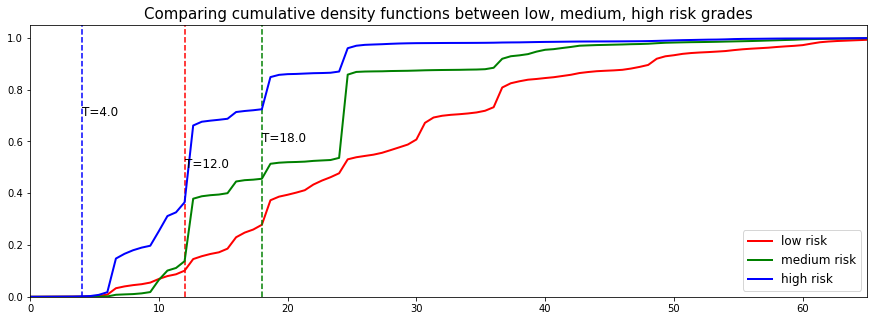

In [43]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Selecting a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting an individual that experienced an event
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the CDF for all times t
    cdf = 1. - neural_mtlr.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(neural_mtlr.times, cdf, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing cumulative density functions between {} risk grades"
title = title.format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.xlim(0, 65)
plt.ylim(0, 1.05)
plt.show()

Como podemos ver, o modelo consegue prever o tempo do evento, aqui corresponde a um aumento súbito na função de velocidade individual de reembolso.

## 8 - Conclusão

Primeiro podemos salvar nosso modelo para colocá-lo em produção e pontuar futuros clientes.


In [38]:
# Let's now save our model
# from pysurvival.utils import save_model
# save_model(neural_mtlr, '/Users/xxx/Desktop/credit_neural_mtlr.zip')

Graças à Análise de Sobrevivência, podemos ver que de fato é possível prever a velocidade de pagamento de empréstimos e prever o número de empréstimos que serão pagos integralmente ao longo do tempo, o que é uma grande vantagem sobre a modelagem de classificação.